In [20]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt 

In [21]:
PATH_DATASETS = ""  # 預設路徑

# 檢查檔案是否已存在的函數
def dataset_exists(path, filename):
    return os.path.exists(os.path.join(path, filename))

# MNIST 資料夾和檔案名稱
mnist_folder = os.path.join(PATH_DATASETS, "MNIST/raw")
mnist_train_file = "train-images-idx3-ubyte.gz"
mnist_test_file = "t10k-images-idx3-ubyte.gz"

# 檢查訓練集和測試集是否存在
if not dataset_exists(mnist_folder, mnist_train_file):
    print("Training dataset not found. Downloading...")
    train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                     transform=transforms.ToTensor())
else:
    print("Training dataset already exists. Skipping download.")
    train_ds = MNIST(PATH_DATASETS, train=True, download=False, 
                     transform=transforms.ToTensor())

if not dataset_exists(mnist_folder, mnist_test_file):
    print("Test dataset not found. Downloading...")
    test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                    transform=transforms.ToTensor())
else:
    print("Test dataset already exists. Skipping download.")
    test_ds = MNIST(PATH_DATASETS, train=False, download=False, 
                    transform=transforms.ToTensor())

Training dataset already exists. Skipping download.
Test dataset already exists. Skipping download.


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

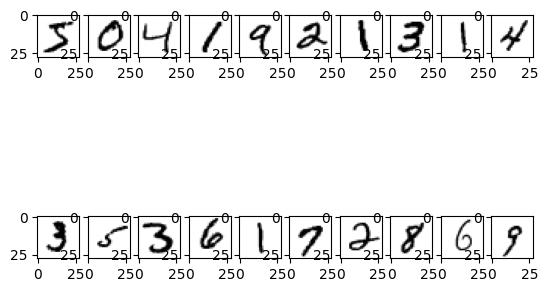

In [23]:
plt.figure()
for i in range(1,21):
    plt.subplot(2,10,i)
    plt.imshow(train_ds.data[i-1], cmap='binary')

In [49]:
model = torch.nn.Sequential().to(device)
model.add_module('conv2d1',torch.nn.Conv2d(1,32,kernel_size=3))
model.add_module('relu1',torch.nn.ReLU())
model.add_module('pooling2d',torch.nn.MaxPool2d(2))
model.add_module('conv2d2',torch.nn.Conv2d(32,64,kernel_size=3))
model.add_module('relu2',torch.nn.ReLU())

In [69]:
model.add_module('flatten',torch.nn.Flatten())
model.add_module('dropout',torch.nn.Dropout(0.2))
model.add_module('dense1',torch.nn.Linear(7744,128))
model.add_module('relu3',torch.nn.ReLU())
model.add_module('dense2',torch.nn.Linear(128,10))

In [51]:
print(model)

Sequential(
  (conv2d1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pooling2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=7744, out_features=128, bias=True)
  (relu3): ReLU()
  (dense2): Linear(in_features=128, out_features=10, bias=True)
)


In [74]:
epochs = 5
lr = 1
BATCH_SIZE = 1024  # 批量

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

# 設定優化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [75]:
model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)',
                  f'Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %) Loss: 0.039945
Epoch 1: [10240 / 60000] (17 %) Loss: 0.025818
Epoch 1: [20480 / 60000] (34 %) Loss: 0.017121
Epoch 1: [30720 / 60000] (51 %) Loss: 0.025594
Epoch 1: [40960 / 60000] (68 %) Loss: 0.020149
Epoch 1: [51200 / 60000] (85 %) Loss: 0.022194
Epoch 2: [    0 / 60000] (0 %) Loss: 0.033907
Epoch 2: [10240 / 60000] (17 %) Loss: 0.025797
Epoch 2: [20480 / 60000] (34 %) Loss: 0.010102
Epoch 2: [30720 / 60000] (51 %) Loss: 0.014280
Epoch 2: [40960 / 60000] (68 %) Loss: 0.017772
Epoch 2: [51200 / 60000] (85 %) Loss: 0.022681
Epoch 3: [    0 / 60000] (0 %) Loss: 0.026576
Epoch 3: [10240 / 60000] (17 %) Loss: 0.025493
Epoch 3: [20480 / 60000] (34 %) Loss: 0.007338
Epoch 3: [30720 / 60000] (51 %) Loss: 0.020518
Epoch 3: [40960 / 60000] (68 %) Loss: 0.013534
Epoch 3: [51200 / 60000] (85 %) Loss: 0.013155
Epoch 4: [    0 / 60000] (0 %) Loss: 0.021664
Epoch 4: [10240 / 60000] (17 %) Loss: 0.018713
Epoch 4: [20480 / 60000] (34 %) Loss: 0.014893
Epoch 4: [30720 /

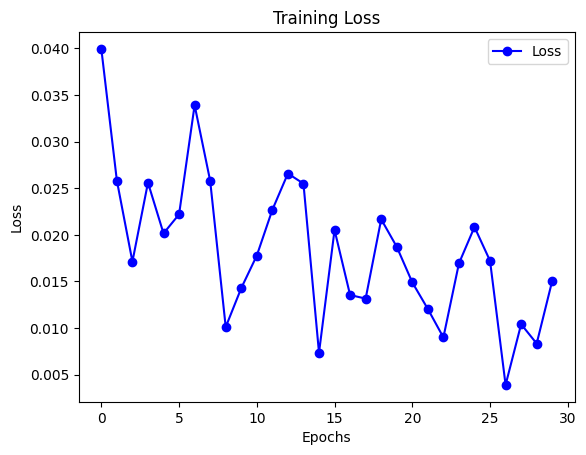

In [76]:
plt.plot(loss_list, label='Loss', color='blue', marker='o')

# 添加标题和标签
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 显示图例
plt.legend()

# 显示图形
plt.show()

In [77]:
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 預測
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
test_loss /= len(test_loader.dataset)
# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = correct / data_count * 100
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage}%)\n')

平均損失: 0.0000, 準確率: 9917/10000 (99.17%)

